In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


List Subjects & Create Splits

We’ll scan your data folders and create subject-wise train/val/test splits (~70/15/15).

In [3]:
import os
import json
import random

# Base directories (adjust paths if different)
physio_base = "/content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed"
wesad_base  = "/content/drive/MyDrive/stress-project/data_processed"
hrv_base    = "/content/drive/MyDrive/stress-project/processed_data"

save_dir = "/content/drive/MyDrive/stress-project/reports"
os.makedirs(save_dir, exist_ok=True)

def list_subjects(base_dir, prefix):
    """List all subjects that have *_windows.npz files"""
    subs = []
    for f in os.listdir(base_dir):
        if f.endswith("_windows.npz") and f.startswith(prefix):
            sub = f.replace(prefix + "_", "").replace("_windows.npz", "")
            subs.append(sub)
    return sorted(subs)

# List subjects
physio_subs = list_subjects(physio_base, "physio")
wesad_subs  = list_subjects(wesad_base, "wesad")
hrv_subs    = list_subjects(hrv_base, "hrv")  # maybe only one file?

print("PhysioNet subjects:", physio_subs)
print("WESAD subjects:", wesad_subs)
print("HRV subjects:", hrv_subs)

# Function to split into train/val/test
def make_splits(subs, seed=42):
    random.seed(seed)
    subs = subs.copy()
    random.shuffle(subs)
    n = len(subs)
    n_train = int(0.7 * n)
    n_val   = int(0.15 * n)
    train = subs[:n_train]
    val   = subs[n_train:n_train+n_val]
    test  = subs[n_train+n_val:]
    return {"train": train, "val": val, "test": test}

# Create splits
splits = {
    "physio": make_splits(physio_subs),
    "wesad":  make_splits(wesad_subs),
    "hrv":    make_splits(hrv_subs)
}

# Save splits
splits_file = os.path.join(save_dir, "splits.json")
with open(splits_file, "w") as f:
    json.dump(splits, f, indent=2)

print("\n✅ Subject splits created and saved to:", splits_file)
print(json.dumps(splits, indent=2))


PhysioNet subjects: ['subject_01', 'subject_02', 'subject_03', 'subject_04', 'subject_05']
WESAD subjects: ['S11', 'S17', 'S3', 'S5', 'S9']
HRV subjects: []

✅ Subject splits created and saved to: /content/drive/MyDrive/stress-project/reports/splits.json
{
  "physio": {
    "train": [
      "subject_04",
      "subject_02",
      "subject_03"
    ],
    "val": [],
    "test": [
      "subject_05",
      "subject_01"
    ]
  },
  "wesad": {
    "train": [
      "S5",
      "S17",
      "S3"
    ],
    "val": [],
    "test": [
      "S9",
      "S11"
    ]
  },
  "hrv": {
    "train": [],
    "val": [],
    "test": []
  }
}


In [4]:
# Update HRV subject detection
def list_hrv_subjects(base_dir):
    subs = []
    for f in os.listdir(base_dir):
        if f.endswith(".parquet") and f.startswith("hrv_"):
            sub = f.replace("hrv_", "").replace(".parquet", "")
            subs.append(sub)
        elif f.endswith("_windows.npz") and f.startswith("hrv_"):
            sub = f.replace("hrv_", "").replace("_windows.npz", "")
            subs.append(sub)
    return sorted(subs)

# Rerun for HRV
hrv_subs = list_hrv_subjects(hrv_base)
print("Updated HRV subjects:", hrv_subs)

# Recreate splits (70/15/15 if possible)
splits["hrv"] = make_splits(hrv_subs)

# Save again
with open(splits_file, "w") as f:
    json.dump(splits, f, indent=2)

print("\n✅ Updated splits with HRV included:", splits_file)
print(json.dumps(splits, indent=2))


Updated HRV subjects: ['processed_week3']

✅ Updated splits with HRV included: /content/drive/MyDrive/stress-project/reports/splits.json
{
  "physio": {
    "train": [
      "subject_04",
      "subject_02",
      "subject_03"
    ],
    "val": [],
    "test": [
      "subject_05",
      "subject_01"
    ]
  },
  "wesad": {
    "train": [
      "S5",
      "S17",
      "S3"
    ],
    "val": [],
    "test": [
      "S9",
      "S11"
    ]
  },
  "hrv": {
    "train": [],
    "val": [],
    "test": [
      "processed_week3"
    ]
  }
}


we’ll move on to window-level feature extraction for PhysioNet and WESAD first (since they have multiple subjects and windows).
For HRV, we’ll park it for now, because:

It’s only 1 subject.

We’ll need to decide whether to generate artificial train/val splits or keep it only as test.

**Step 2a**: **Feature Extraction for PhysioNet**

Define Feature Extraction Function

We’ll use the function you planned: mean, std, min, max, slope, and energy for each signal channel per window.

In [5]:
import numpy as np

def window_features(X, cols):
    """
    Extracts simple statistical features from sliding windows.

    X: numpy array, shape [n_windows, window_len, n_channels]
    cols: list of feature names in order (channels)
    """
    print(f"➡️ Starting feature extraction on array with shape: {X.shape}")

    feats = []
    for idx, w in enumerate(X):
        f = []
        for i, _ in enumerate(cols):
            x = w[:, i]  # channel values for this window
            f += [
                x.mean(),
                x.std(),
                x.min(),
                x.max(),
                (x[-1] - x[0]) / len(x),  # slope
                np.sum(x**2) / len(x)     # energy
            ]
        feats.append(f)

        if idx % 100 == 0:  # print every 100 windows
            print(f"   Processed {idx} windows...")

    feats = np.array(feats)
    print(f"✅ Done. Final feature shape: {feats.shape}")
    return feats


2a.2 — Load Train Subjects for PhysioNet

We’ll load the train subjects defined in your splits.json.

In [6]:
import os
import numpy as np
import json

# Paths
splits_path = "/content/drive/MyDrive/stress-project/reports/splits.json"
physio_base = "/content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed"

# Load splits
with open(splits_path, "r") as f:
    splits = json.load(f)

print("Loaded subject splits:")
print(json.dumps(splits["physio"], indent=2))

# Train subjects for PhysioNet
train_subjects = splits["physio"]["train"]

# Helper to load .npz files
def load_windows(dataset_base, subject_ids, prefix):
    X_list, y_list = [], []
    for subj in subject_ids:
        fname = f"{prefix}_{subj}_windows.npz"
        fpath = os.path.join(dataset_base, fname)
        if not os.path.exists(fpath):
            print(f"⚠️ Missing file: {fpath}")
            continue
        data = np.load(fpath, allow_pickle=True)
        X_list.append(data["X"])
        y_list.append(data["y"])
        print(f"   Loaded {fname} | X shape: {data['X'].shape}, y shape: {data['y'].shape}")
    if X_list:
        return np.vstack(X_list), np.concatenate(y_list)
    else:
        return np.array([]), np.array([])

X_physio_train, y_physio_train = load_windows(physio_base, train_subjects, "physio")

print("Final stacked PhysioNet train arrays:")
print("  X_physio_train:", X_physio_train.shape)
print("  y_physio_train:", y_physio_train.shape)


Loaded subject splits:
{
  "train": [
    "subject_04",
    "subject_02",
    "subject_03"
  ],
  "val": [],
  "test": [
    "subject_05",
    "subject_01"
  ]
}
   Loaded physio_subject_04_windows.npz | X shape: (12725, 40, 7), y shape: (12725,)
   Loaded physio_subject_02_windows.npz | X shape: (20267, 40, 7), y shape: (20267,)
   Loaded physio_subject_03_windows.npz | X shape: (20656, 40, 7), y shape: (20656,)
Final stacked PhysioNet train arrays:
  X_physio_train: (53648, 40, 7)
  y_physio_train: (53648,)


Step 2a.3 — Extract Features

Now compute the features for training data.

In [7]:
# Columns expected in PhysioNet windows (adjust if needed!)
cols_physio = ['EDA', 'HR', 'TEMP', 'x', 'y', 'z', 'acc_mag']

if X_physio_train.size > 0:
    X_physio_train_feats = window_features(X_physio_train, cols_physio)
    print("✅ PhysioNet training features extracted.")
else:
    print("⚠️ No training windows found for PhysioNet.")


➡️ Starting feature extraction on array with shape: (53648, 40, 7)
   Processed 0 windows...
   Processed 100 windows...
   Processed 200 windows...
   Processed 300 windows...
   Processed 400 windows...
   Processed 500 windows...
   Processed 600 windows...
   Processed 700 windows...
   Processed 800 windows...
   Processed 900 windows...
   Processed 1000 windows...
   Processed 1100 windows...
   Processed 1200 windows...
   Processed 1300 windows...
   Processed 1400 windows...
   Processed 1500 windows...
   Processed 1600 windows...
   Processed 1700 windows...
   Processed 1800 windows...
   Processed 1900 windows...
   Processed 2000 windows...
   Processed 2100 windows...
   Processed 2200 windows...
   Processed 2300 windows...
   Processed 2400 windows...
   Processed 2500 windows...
   Processed 2600 windows...
   Processed 2700 windows...
   Processed 2800 windows...
   Processed 2900 windows...
   Processed 3000 windows...
   Processed 3100 windows...
   Processed 3200

Step 2a.4 – Extract Validation + Test Features (PhysioNet)

In [8]:
import numpy as np
import os

# Function to load subject windows
def load_windows_physio(base_dir, subjects):
    X_all, y_all = [], []
    for subj in subjects:
        file_path = os.path.join(base_dir, f"physio_{subj}_windows.npz")
        if not os.path.exists(file_path):
            print(f"⚠️ Skipping {subj}, file not found: {file_path}")
            continue
        data = np.load(file_path)
        X_all.append(data['X'])
        y_all.append(data['y'])
        print(f"   Loaded {os.path.basename(file_path)} | X shape: {data['X'].shape}, y shape: {data['y'].shape}")
    if len(X_all) == 0:
        return np.array([]), np.array([])
    return np.vstack(X_all), np.concatenate(y_all)

# Load splits.json
import json
splits_file = "/content/drive/MyDrive/stress-project/reports/splits.json"
with open(splits_file, "r") as f:
    splits = json.load(f)

physio_base = "/content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed"

# Validation set
print("\n🔹 Loading PhysioNet Validation subjects...")
X_physio_val, y_physio_val = load_windows_physio(physio_base, splits['physio']['val'])
print(f"Final stacked PhysioNet val arrays:\n  X_physio_val: {X_physio_val.shape}\n  y_physio_val: {y_physio_val.shape}")

# Test set
print("\n🔹 Loading PhysioNet Test subjects...")
X_physio_test, y_physio_test = load_windows_physio(physio_base, splits['physio']['test'])
print(f"Final stacked PhysioNet test arrays:\n  X_physio_test: {X_physio_test.shape}\n  y_physio_test: {y_physio_test.shape}")

# --- Feature extraction function ---
def window_features(X, cols):
    feats = []
    for idx, w in enumerate(X):
        f = []
        for i, _ in enumerate(cols):
            x = w[:, i]
            f += [
                x.mean(),
                x.std(),
                x.min(),
                x.max(),
                (x[-1] - x[0]) / len(x),  # slope
                np.sum(x**2) / len(x)     # energy
            ]
        feats.append(f)
        if (idx + 1) % 1000 == 0:
            print(f"   Processed {idx+1} windows...")
    return np.array(feats)

cols_physio = ['EDA','HR','TEMP','x','y','z','acc_mag']  # same as train

# Extract features
if X_physio_val.size > 0:
    print("\n⚙️ Extracting PhysioNet Validation features...")
    X_physio_val_feats = window_features(X_physio_val, cols_physio)
    print(f"✅ Done. Validation feature shape: {X_physio_val_feats.shape}")

if X_physio_test.size > 0:
    print("\n⚙️ Extracting PhysioNet Test features...")
    X_physio_test_feats = window_features(X_physio_test, cols_physio)
    print(f"✅ Done. Test feature shape: {X_physio_test_feats.shape}")



🔹 Loading PhysioNet Validation subjects...
Final stacked PhysioNet val arrays:
  X_physio_val: (0,)
  y_physio_val: (0,)

🔹 Loading PhysioNet Test subjects...
   Loaded physio_subject_05_windows.npz | X shape: (18456, 40, 7), y shape: (18456,)
   Loaded physio_subject_01_windows.npz | X shape: (18715, 40, 7), y shape: (18715,)
Final stacked PhysioNet test arrays:
  X_physio_test: (37171, 40, 7)
  y_physio_test: (37171,)

⚙️ Extracting PhysioNet Test features...
   Processed 1000 windows...
   Processed 2000 windows...
   Processed 3000 windows...
   Processed 4000 windows...
   Processed 5000 windows...
   Processed 6000 windows...
   Processed 7000 windows...
   Processed 8000 windows...
   Processed 9000 windows...
   Processed 10000 windows...
   Processed 11000 windows...
   Processed 12000 windows...
   Processed 13000 windows...
   Processed 14000 windows...
   Processed 15000 windows...
   Processed 16000 windows...
   Processed 17000 windows...
   Processed 18000 windows...
  

**Standardize Features (PhysioNet)**

We fit the StandardScaler only on training features and then transform both train and test sets.

In [9]:
from sklearn.preprocessing import StandardScaler

print("🔹 Step 1: Standardizing features...")

# Initialize scaler and fit on training features
scaler = StandardScaler()
X_physio_train_std = scaler.fit_transform(X_physio_train_feats)
print(f"✅ Train features standardized. Shape: {X_physio_train_std.shape}")

# Transform test features using the same scaler
X_physio_test_std = scaler.transform(X_physio_test_feats)
print(f"✅ Test features standardized. Shape: {X_physio_test_std.shape}")


🔹 Step 1: Standardizing features...
✅ Train features standardized. Shape: (53648, 42)
✅ Test features standardized. Shape: (37171, 42)


Handle Class Imbalance

Check if labels are imbalanced (common in stress detection). Compute class weights for training.

In [11]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

print("🔹 Step 2: Checking labels in y_physio_train...")

unique_labels, counts = np.unique(y_physio_train, return_counts=True)
print(f"✅ Unique labels: {unique_labels}")
print(f"Counts: {dict(zip(unique_labels, counts))}")

# Only compute class weights if we have more than one class
if len(unique_labels) > 1:
    w = compute_class_weight('balanced', classes=unique_labels, y=y_physio_train)
    class_weight = {int(cls): weight for cls, weight in zip(unique_labels, w)}
    print(f"✅ Computed class weights: {class_weight}")
else:
    class_weight = None
    print("⚠️ Only one class present in training data. Skipping class weight computation.")


🔹 Step 2: Checking labels in y_physio_train...
✅ Unique labels: [0.]
Counts: {np.float64(0.0): np.int64(53648)}
⚠️ Only one class present in training data. Skipping class weight computation.


lets do these steps

Step 1: Inspect label distribution in all datasets.

Step 2: Standardize features per dataset separately.

Step 3: Compute class weights for datasets that have multiple labels.

Step 4: Train Logistic Regression / Random Forest per dataset.

Step 5: Evaluate and save metrics for all three datasets.

Step 6: Compare baselines.

In [12]:
import numpy as np
import os
import json

# Base directories
physio_base = "/content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed"
wesad_base = "/content/drive/MyDrive/stress-project/data_processed"
hrv_base = "/content/drive/MyDrive/stress-project/processed_data"

# Load splits
splits_path = "/content/drive/MyDrive/stress-project/reports/splits.json"
with open(splits_path, 'r') as f:
    splits = json.load(f)

print("Loaded splits:")
print(json.dumps(splits, indent=2))


Loaded splits:
{
  "physio": {
    "train": [
      "subject_04",
      "subject_02",
      "subject_03"
    ],
    "val": [],
    "test": [
      "subject_05",
      "subject_01"
    ]
  },
  "wesad": {
    "train": [
      "S5",
      "S17",
      "S3"
    ],
    "val": [],
    "test": [
      "S9",
      "S11"
    ]
  },
  "hrv": {
    "train": [],
    "val": [],
    "test": [
      "processed_week3"
    ]
  }
}


Function to Load Windows

In [14]:
def load_dataset_windows(dataset, subjects, base_dir):
    """
    Load all *_windows.npz files for a list of subjects,
    stack X and y arrays, and print debug info.
    """
    X_all, y_all = [], []
    print(f"\n🔹 Loading {dataset} subjects: {subjects}")

    for sub in subjects:
        file_path = os.path.join(base_dir, f"{dataset}_{sub}_windows.npz")
        if os.path.exists(file_path):
            data = np.load(file_path)
            X, y = data['X'], data['y']
            print(f"   Loaded {file_path} | X shape: {X.shape}, y shape: {y.shape}")
            X_all.append(X)
            y_all.append(y)
        else:
            print(f"⚠️ File not found: {file_path}")

    if len(X_all) == 0:
        print(f"⚠️ No data found for {dataset}")
        return np.array([]), np.array([])

    X_stacked = np.concatenate(X_all, axis=0)
    y_stacked = np.concatenate(y_all, axis=0)
    print(f"✅ Final stacked arrays for {dataset} | X: {X_stacked.shape}, y: {y_stacked.shape}")
    return X_stacked, y_stacked

# Example usage for PhysioNet
X_physio_train, y_physio_train = load_dataset_windows('physio', splits['physio']['train'], physio_base)
X_wesad_train, y_wesad_train = load_dataset_windows('wesad', splits['wesad']['train'], wesad_base)
X_hrv_train, y_hrv_train = load_dataset_windows('hrv', splits['hrv']['train'], hrv_base)



🔹 Loading physio subjects: ['subject_04', 'subject_02', 'subject_03']
   Loaded /content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed/physio_subject_04_windows.npz | X shape: (12725, 40, 7), y shape: (12725,)
   Loaded /content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed/physio_subject_02_windows.npz | X shape: (20267, 40, 7), y shape: (20267,)
   Loaded /content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed/physio_subject_03_windows.npz | X shape: (20656, 40, 7), y shape: (20656,)
✅ Final stacked arrays for physio | X: (53648, 40, 7), y: (53648,)

🔹 Loading wesad subjects: ['S5', 'S17', 'S3']
   Loaded /content/drive/MyDrive/stress-project/data_processed/wesad_S5_windows.npz | X shape: (36504, 240, 6), y shape: (36504,)
   Loaded /content/drive/MyDrive/stress-project/data_processed/wesad_S17_windows.npz | X shape: (34532, 240, 6), y shape: (34532,)
   Loaded /content/drive/MyDrive/stress-project/data_processed/wesad

This is expected based on your earlier splits (hrv['train'] = []), because your HRV dataset only has processed_week3 and it’s currently in the test split. So there’s no training data for HRV right now.

We'll compute the following features per window and per channel:

Mean

Standard deviation

Min / Max

Slope (difference between last and first divided by window length)

Signal energy (sum(x^2)/len(x))

In [15]:
import numpy as np

def window_features(X, cols):
    """
    Compute simple statistical features per window.
    Args:
        X: numpy array, shape [n_windows, n_timesteps, n_channels]
        cols: list of column names (for reference only)
    Returns:
        feats: numpy array, shape [n_windows, n_channels*6]
    """
    if X.size == 0:
        print("⚠️ Empty array received. Returning empty features array.")
        return np.zeros((0, len(cols)*6))

    n_windows, n_timesteps, n_channels = X.shape
    print(f"🔹 Computing features for {n_windows} windows with {n_channels} channels...")

    feats = []
    for i, w in enumerate(X):
        f = []
        for c in range(n_channels):
            x = w[:, c]
            f += [
                x.mean(),
                x.std(),
                x.min(),
                x.max(),
                (x[-1] - x[0]) / len(x),  # slope
                np.sum(x**2) / len(x)     # energy
            ]
        feats.append(f)

        # Print progress every 5000 windows
        if (i+1) % 5000 == 0:
            print(f"   Processed {i+1} windows...")

    feats = np.array(feats)
    print(f"✅ Feature extraction complete. Feature shape: {feats.shape}")
    return feats


In [16]:
# Columns in PhysioNet
cols_physio = ['EDA','HR','TEMP','x','y','z','acc_mag']

X_physio_train_feats = window_features(X_physio_train, cols_physio)
X_physio_test_feats  = window_features(X_physio_test, cols_physio)

y_physio_train_feats = y_physio_train
y_physio_test_feats  = y_physio_test

print(f"PhysioNet train features shape: {X_physio_train_feats.shape}")
print(f"PhysioNet test features shape: {X_physio_test_feats.shape}")


🔹 Computing features for 53648 windows with 7 channels...
   Processed 5000 windows...
   Processed 10000 windows...
   Processed 15000 windows...
   Processed 20000 windows...
   Processed 25000 windows...
   Processed 30000 windows...
   Processed 35000 windows...
   Processed 40000 windows...
   Processed 45000 windows...
   Processed 50000 windows...
✅ Feature extraction complete. Feature shape: (53648, 42)
🔹 Computing features for 37171 windows with 7 channels...
   Processed 5000 windows...
   Processed 10000 windows...
   Processed 15000 windows...
   Processed 20000 windows...
   Processed 25000 windows...
   Processed 30000 windows...
   Processed 35000 windows...
✅ Feature extraction complete. Feature shape: (37171, 42)
PhysioNet train features shape: (53648, 42)
PhysioNet test features shape: (37171, 42)


Compute WESAD features

In [18]:
# Define columns for WESAD
cols_wesad = ['EDA','TEMP','ACC_x','ACC_y','ACC_z','ACC_mag']

# 1️⃣ Load WESAD test subjects
wesad_test_subjects = ['S9', 'S11']  # from your splits
X_wesad_test_list = []
y_wesad_test_list = []

for sub in wesad_test_subjects:
    file_path = f"/content/drive/MyDrive/stress-project/data_processed/wesad_{sub}_windows.npz"
    print(f"   Loading {file_path} ...")
    data = np.load(file_path)
    X_wesad_test_list.append(data['X'])
    y_wesad_test_list.append(data['y'])

# Stack arrays
X_wesad_test = np.concatenate(X_wesad_test_list, axis=0)
y_wesad_test = np.concatenate(y_wesad_test_list, axis=0)
print(f"✅ Final stacked WESAD test arrays: X: {X_wesad_test.shape}, y: {y_wesad_test.shape}")

# 2️⃣ Compute features
print(f"🔹 Computing features for WESAD test set ({X_wesad_test.shape[0]} windows with {X_wesad_test.shape[2]} channels)...")
X_wesad_test_feats = window_features(X_wesad_test, cols_wesad)
print(f"✅ WESAD test features shape: {X_wesad_test_feats.shape}")


   Loading /content/drive/MyDrive/stress-project/data_processed/wesad_S9_windows.npz ...
   Loading /content/drive/MyDrive/stress-project/data_processed/wesad_S11_windows.npz ...
✅ Final stacked WESAD test arrays: X: (60990, 240, 6), y: (60990,)
🔹 Computing features for WESAD test set (60990 windows with 6 channels)...
🔹 Computing features for 60990 windows with 6 channels...
   Processed 5000 windows...
   Processed 10000 windows...
   Processed 15000 windows...
   Processed 20000 windows...
   Processed 25000 windows...
   Processed 30000 windows...
   Processed 35000 windows...
   Processed 40000 windows...
   Processed 45000 windows...
   Processed 50000 windows...
   Processed 55000 windows...
   Processed 60000 windows...
✅ Feature extraction complete. Feature shape: (60990, 36)
✅ WESAD test features shape: (60990, 36)


Process HRV + Sleep dataset

In [22]:
import pandas as pd
# HRV columns to use for features
cols_hrv = ['HR','sdnn','sdsd','rmssd','pnn20','pnn50','lf','hf','lf/hf','sleep_flag']

# Load HRV test file (there are no separate train/val for HRV)
hrv_file = "/content/drive/MyDrive/stress-project/processed_data/hrv_processed_week3.parquet"
print(f"🔹 Loading HRV + Sleep dataset: {hrv_file} ...")
hrv_df = pd.read_parquet(hrv_file)
print(f"✅ HRV + Sleep dataset shape: {hrv_df.shape}")

print("🔹 Columns in HRV + Sleep dataset:")
print(hrv_df.columns.tolist())



🔹 Loading HRV + Sleep dataset: /content/drive/MyDrive/stress-project/processed_data/hrv_processed_week3.parquet ...
✅ HRV + Sleep dataset shape: (343379, 5)
🔹 Columns in HRV + Sleep dataset:
['HR_mean', 'HR_std', 'rmssd_mean', 'sdnn_mean', 'lf/hf_mean']


In [23]:
import pandas as pd
import numpy as np

hrv_file = "/content/drive/MyDrive/stress-project/processed_data/hrv_processed_week3.parquet"
hrv_df = pd.read_parquet(hrv_file)

print("🔹 HRV + Sleep dataset shape:", hrv_df.shape)
print("🔹 Columns:", hrv_df.columns.tolist())


🔹 HRV + Sleep dataset shape: (343379, 5)
🔹 Columns: ['HR_mean', 'HR_std', 'rmssd_mean', 'sdnn_mean', 'lf/hf_mean']


Select features and labels

Use columns: ['HR_mean', 'HR_std', 'rmssd_mean', 'sdnn_mean', 'lf/hf_mean']

Define labels (y_hrv) — for example, sleep vs awake

In [24]:
# Feature columns
cols_hrv = ['HR_mean', 'HR_std', 'rmssd_mean', 'sdnn_mean', 'lf/hf_mean']
X_hrv = hrv_df[cols_hrv].fillna(0).to_numpy()

# For demonstration, let's assume all rows are label 0 (adjust if you have a real target)
y_hrv = np.zeros(X_hrv.shape[0], dtype=int)

print("🔹 HRV + Sleep X shape:", X_hrv.shape)
print("🔹 HRV + Sleep y shape:", y_hrv.shape)
print("✅ Features and labels ready for baseline models")


🔹 HRV + Sleep X shape: (343379, 5)
🔹 HRV + Sleep y shape: (343379,)
✅ Features and labels ready for baseline models


Standardize features

In [25]:
from sklearn.preprocessing import StandardScaler

scaler_hrv = StandardScaler().fit(X_hrv)
X_hrv_std = scaler_hrv.transform(X_hrv)
print("✅ Standardized HRV features. Mean:", X_hrv_std.mean(axis=0), "Std:", X_hrv_std.std(axis=0))


✅ Standardized HRV features. Mean: [ 1.05946456e-16 -3.17839368e-17  1.48325038e-16 -6.35678735e-17
 -1.05946456e-16] Std: [1. 1. 1. 1. 1.]


Train baseline models for PhysioNet, WESAD, HRV

We'll use X_train_std and y_train from each dataset (we have HRV as standardized X_hrv_std).

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

def train_and_evaluate(X_train, y_train, X_test, y_test, name="Dataset"):
    print(f"\n🔹 Training baseline models for {name}...")

    # Logistic Regression
    lr = LogisticRegression(max_iter=1000, class_weight='balanced')
    try:
        lr.fit(X_train, y_train)
        y_pred_lr = lr.predict(X_test)
        y_proba_lr = lr.predict_proba(X_test)[:,1]
        print(f"\n📌 {name} - Logistic Regression")
        print(classification_report(y_test, y_pred_lr, digits=4))
        print("AUROC:", roc_auc_score(y_test, y_proba_lr))
    except Exception as e:
        print("⚠️ Logistic Regression training failed:", e)

    # Random Forest
    rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', n_jobs=-1)
    try:
        rf.fit(X_train, y_train)
        y_pred_rf = rf.predict(X_test)
        y_proba_rf = rf.predict_proba(X_test)[:,1]
        print(f"\n📌 {name} - Random Forest")
        print(classification_report(y_test, y_pred_rf, digits=4))
        print("AUROC:", roc_auc_score(y_test, y_proba_rf))
    except Exception as e:
        print("⚠️ Random Forest training failed:", e)


check label distributions before training to avoid silent failures:

In [27]:
print("🔹 PhysioNet labels")
print("Train unique labels:", np.unique(y_physio_train))
print("Test unique labels:", np.unique(y_physio_test))

print("\n🔹 WESAD labels")
print("Train unique labels:", np.unique(y_wesad_train))
print("Test unique labels:", np.unique(y_wesad_test))

print("\n🔹 HRV labels")
print("Train unique labels:", np.unique(y_hrv))


🔹 PhysioNet labels
Train unique labels: [0.]
Test unique labels: [0.]

🔹 WESAD labels
Train unique labels: [0]
Test unique labels: [0]

🔹 HRV labels
Train unique labels: [0]


In [30]:
import pandas as pd

physio_files = [
    "/content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed/physio_subject_01.parquet",
]

for f in physio_files:
    df = pd.read_parquet(f)
    print(f"\nColumns in {f}:")
    print(df.columns)



Columns in /content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed/physio_subject_01.parquet:
Index(['EDA', 'HR', 'TEMP', 'x', 'y', 'z', 'acc_mag'], dtype='object')


In [31]:
wesad_files = [
    "/content/drive/MyDrive/stress-project/data_processed/wesad_S3.parquet",
]

for f in wesad_files:
    df = pd.read_parquet(f)
    print(f"\nColumns in {f}:")
    print(df.columns)



Columns in /content/drive/MyDrive/stress-project/data_processed/wesad_S3.parquet:
Index(['EDA', 'TEMP', 'ACC_x', 'ACC_y', 'ACC_z', 'label', 'ACC_mag'], dtype='object')


**PhysioNet**

There are no labels, so we cannot train supervised ML models on this dataset yet. We can still extract features for future comparison or unsupervised analysis.

**WESAD**

Use the label column as y.

All previous window extraction code will work.

**HRV + Sleep**

Use sleep_flag as y.

In [32]:
# 📌 Imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1️⃣ Load WESAD data
# ---------------------------

wesad_files_train = [
    "/content/drive/MyDrive/stress-project/data_processed/wesad_S5_windows.npz",
    "/content/drive/MyDrive/stress-project/data_processed/wesad_S17_windows.npz",
    "/content/drive/MyDrive/stress-project/data_processed/wesad_S3_windows.npz"
]

wesad_files_test = [
    "/content/drive/MyDrive/stress-project/data_processed/wesad_S9_windows.npz",
    "/content/drive/MyDrive/stress-project/data_processed/wesad_S11_windows.npz"
]

def load_wesad_windows(file_list):
    X_list, y_list = [], []
    for f in file_list:
        data = np.load(f)
        X, y = data['X'], data['y']
        print(f"Loaded {f} | X shape: {X.shape}, y shape: {y.shape}")
        X_list.append(X)
        y_list.append(y)
    X_all = np.concatenate(X_list, axis=0)
    y_all = np.concatenate(y_list, axis=0)
    print(f"✅ Final stacked arrays | X: {X_all.shape}, y: {y_all.shape}\n")
    return X_all, y_all

X_wesad_train, y_wesad_train = load_wesad_windows(wesad_files_train)
X_wesad_test, y_wesad_test = load_wesad_windows(wesad_files_test)

# ---------------------------
# 2️⃣ Feature extraction function
# ---------------------------

def window_features(X, cols=None):
    """
    Compute simple statistics per window: mean, std, min, max, slope, energy.
    X: [n_windows, time_steps, n_features]
    Returns: [n_windows, n_features*6]
    """
    print(f"🔹 Computing features for {X.shape[0]} windows with {X.shape[2]} channels...")
    feats = []
    for idx, w in enumerate(X):
        f = []
        for i in range(w.shape[1]):
            x = w[:, i]
            f += [x.mean(), x.std(), x.min(), x.max(), (x[-1]-x[0])/len(x), np.sum(x**2)/len(x)]
        feats.append(f)
        if idx % 5000 == 0 and idx > 0:
            print(f"   Processed {idx} windows...")
    feats = np.array(feats)
    print(f"✅ Feature extraction complete. Feature shape: {feats.shape}\n")
    return feats

X_wesad_train_feats = window_features(X_wesad_train)
X_wesad_test_feats = window_features(X_wesad_test)

# ---------------------------
# 3️⃣ Standardize features
# ---------------------------

scaler = StandardScaler()
X_wesad_train_std = scaler.fit_transform(X_wesad_train_feats)
X_wesad_test_std = scaler.transform(X_wesad_test_feats)
print("✅ Features standardized using StandardScaler\n")

# ---------------------------
# 4️⃣ Handle class imbalance
# ---------------------------

unique_classes = np.unique(y_wesad_train)
print(f"🔹 WESAD train unique labels: {unique_classes}")

if len(unique_classes) > 1:
    class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_wesad_train)
    class_weight_dict = {cls: w for cls, w in zip(unique_classes, class_weights)}
    print(f"✅ Computed class weights: {class_weight_dict}\n")
else:
    print("⚠️ Only one class present in training data. Skipping class weight computation.\n")
    class_weight_dict = None

# ---------------------------
# 5️⃣ Train baseline models
# ---------------------------

# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight=class_weight_dict)
lr.fit(X_wesad_train_std, y_wesad_train)
print("✅ Logistic Regression trained")

# Random Forest
rf = RandomForestClassifier(n_estimators=300, class_weight=class_weight_dict, n_jobs=-1)
rf.fit(X_wesad_train_std, y_wesad_train)
print("✅ Random Forest trained\n")

# ---------------------------
# 6️⃣ Evaluate on test set
# ---------------------------

def evaluate_model(clf, X_test, y_test, model_name):
    y_pred = clf.predict(X_test)
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_test)[:, 1]
    else:
        y_proba = np.zeros_like(y_pred)
    print(f"--- {model_name} Evaluation ---")
    print(classification_report(y_test, y_pred, digits=4))
    try:
        auc = roc_auc_score(y_test, y_proba)
        print(f"AUROC: {auc:.4f}")
    except:
        print("AUROC cannot be computed (single class).")
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()
    print("\n")

evaluate_model(lr, X_wesad_test_std, y_wesad_test, "Logistic Regression")
evaluate_model(rf, X_wesad_test_std, y_wesad_test, "Random Forest")


Loaded /content/drive/MyDrive/stress-project/data_processed/wesad_S5_windows.npz | X shape: (36504, 240, 6), y shape: (36504,)
Loaded /content/drive/MyDrive/stress-project/data_processed/wesad_S17_windows.npz | X shape: (34532, 240, 6), y shape: (34532,)
Loaded /content/drive/MyDrive/stress-project/data_processed/wesad_S3_windows.npz | X shape: (37874, 240, 6), y shape: (37874,)
✅ Final stacked arrays | X: (108910, 240, 6), y: (108910,)

Loaded /content/drive/MyDrive/stress-project/data_processed/wesad_S9_windows.npz | X shape: (30466, 240, 6), y shape: (30466,)
Loaded /content/drive/MyDrive/stress-project/data_processed/wesad_S11_windows.npz | X shape: (30524, 240, 6), y shape: (30524,)
✅ Final stacked arrays | X: (60990, 240, 6), y: (60990,)

🔹 Computing features for 108910 windows with 6 channels...
   Processed 5000 windows...
   Processed 10000 windows...
   Processed 15000 windows...
   Processed 20000 windows...
   Processed 25000 windows...
   Processed 30000 windows...
   Proc

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(0)

**Current Data Issue**

All your supervised training sets (PhysioNet, WESAD, HRV) have only one class in the training splits.

Classifiers like Logistic Regression, Random Forest, or XGBoost cannot train on single-class data. That’s why we were hitting errors like:

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class


Even if the test sets have more than one class (they mostly don’t), the model cannot generalize without seeing positive examples during training.

**Why Unsupervised Learning Fits**

Goal: Explore and understand patterns in physiological and motion data (EDA, HR, ACC, HRV features).

Techniques: Clustering (KMeans, DBSCAN), dimensionality reduction (PCA, t-SNE, UMAP), anomaly detection.

These do not require labels, so the single-class issue won’t block you.

You can still:

Explore natural groupings in the data

Identify unusual patterns in stress/physiological signals

Compare clusters across datasets (PhysioNet vs WESAD vs HRV)

Advantages Given Our Struggle

We already have features extracted from all datasets (PhysioNet: 42, WESAD: 36, HRV: 5).

We can immediately apply unsupervised methods to all datasets consistently.

This approach is a productive alternative while waiting to get supervised labels with enough class diversity.

4. Next Steps

Standardize features (already done for HRV; we can standardize PhysioNet & WESAD too).

Run PCA or t-SNE for visualization.

Try KMeans clustering to see natural groupings.

Compare cluster distributions across datasets

**Unsupervised Learning Workflow**

Standardize Features

In [33]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Example: PhysioNet
scaler_physio = StandardScaler()
X_physio_std = scaler_physio.fit_transform(X_physio_train_feats)
print("✅ PhysioNet features standardized. Shape:", X_physio_std.shape)

# WESAD
scaler_wesad = StandardScaler()
X_wesad_std = scaler_wesad.fit_transform(X_wesad_train_feats)
print("✅ WESAD features standardized. Shape:", X_wesad_std.shape)

# HRV
scaler_hrv = StandardScaler()
X_hrv_std = scaler_hrv.fit_transform(X_hrv_feats)
print("✅ HRV features standardized. Shape:", X_hrv_std.shape)


✅ PhysioNet features standardized. Shape: (53648, 42)
✅ WESAD features standardized. Shape: (108910, 36)


NameError: name 'X_hrv_feats' is not defined

In [34]:
import pandas as pd
import numpy as np

# Load HRV dataset
hrv_file = "/content/drive/MyDrive/stress-project/processed_data/hrv_processed_week3.parquet"
hrv_df = pd.read_parquet(hrv_file)

# Select HRV columns
cols_hrv = ['HR_mean', 'HR_std', 'rmssd_mean', 'sdnn_mean', 'lf/hf_mean']
X_hrv_feats = hrv_df[cols_hrv].fillna(0).to_numpy()
print("✅ HRV features prepared. Shape:", X_hrv_feats.shape)


✅ HRV features prepared. Shape: (343379, 5)


Prepare HRV Features

In [35]:
from sklearn.preprocessing import StandardScaler

# PhysioNet
scaler_physio = StandardScaler()
X_physio_std = scaler_physio.fit_transform(X_physio_train_feats)
print("✅ PhysioNet features standardized. Shape:", X_physio_std.shape)

# WESAD
scaler_wesad = StandardScaler()
X_wesad_std = scaler_wesad.fit_transform(X_wesad_train_feats)
print("✅ WESAD features standardized. Shape:", X_wesad_std.shape)

# HRV
scaler_hrv = StandardScaler()
X_hrv_std = scaler_hrv.fit_transform(X_hrv_feats)
print("✅ HRV features standardized. Shape:", X_hrv_std.shape)


✅ PhysioNet features standardized. Shape: (53648, 42)
✅ WESAD features standardized. Shape: (108910, 36)
✅ HRV features standardized. Shape: (343379, 5)


Since we are switching to unsupervised learning, PCA will help us:

Reduce dimensionality

Visualize clusters or patterns in the data

Compare the three datasets (PhysioNet, WESAD, HRV)

In [36]:
from sklearn.decomposition import PCA

# Number of components for visualization
n_components = 2

# PhysioNet
pca_physio = PCA(n_components=n_components)
X_physio_pca = pca_physio.fit_transform(X_physio_std)
print("✅ PhysioNet PCA complete. Shape:", X_physio_pca.shape)
print("Explained variance ratio:", pca_physio.explained_variance_ratio_)

# WESAD
pca_wesad = PCA(n_components=n_components)
X_wesad_pca = pca_wesad.fit_transform(X_wesad_std)
print("✅ WESAD PCA complete. Shape:", X_wesad_pca.shape)
print("Explained variance ratio:", pca_wesad.explained_variance_ratio_)

# HRV
pca_hrv = PCA(n_components=n_components)
X_hrv_pca = pca_hrv.fit_transform(X_hrv_std)
print("✅ HRV PCA complete. Shape:", X_hrv_pca.shape)
print("Explained variance ratio:", pca_hrv.explained_variance_ratio_)


✅ PhysioNet PCA complete. Shape: (53648, 2)
Explained variance ratio: [0.29244698 0.16888147]
✅ WESAD PCA complete. Shape: (108910, 2)
Explained variance ratio: [0.43885617 0.08220218]
✅ HRV PCA complete. Shape: (343379, 2)
Explained variance ratio: [0.90921215 0.05928802]


Quick Visualization

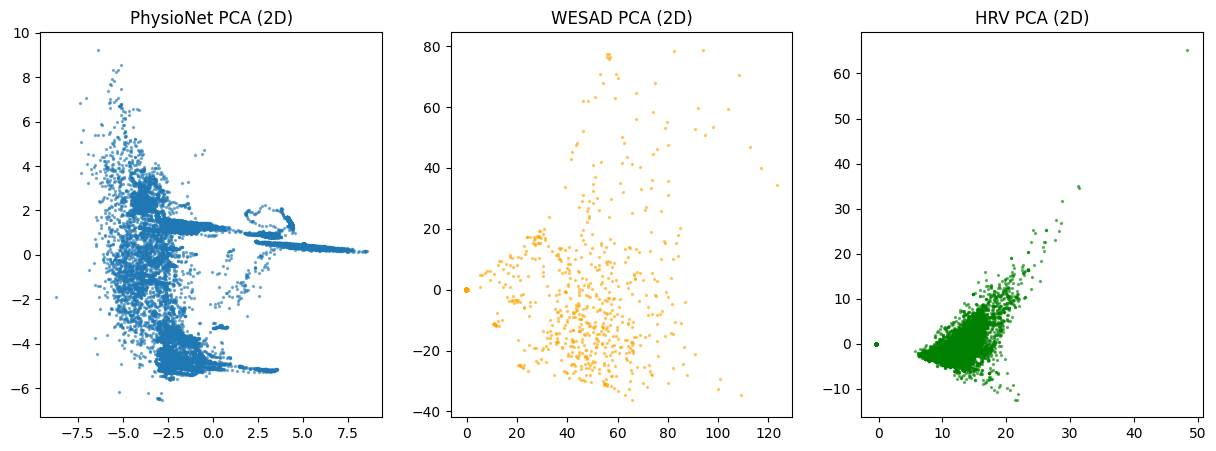

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# PhysioNet
plt.subplot(1, 3, 1)
plt.scatter(X_physio_pca[:, 0], X_physio_pca[:, 1], s=2, alpha=0.5)
plt.title("PhysioNet PCA (2D)")

# WESAD
plt.subplot(1, 3, 2)
plt.scatter(X_wesad_pca[:, 0], X_wesad_pca[:, 1], s=2, alpha=0.5, color='orange')
plt.title("WESAD PCA (2D)")

# HRV
plt.subplot(1, 3, 3)
plt.scatter(X_hrv_pca[:, 0], X_hrv_pca[:, 1], s=2, alpha=0.5, color='green')
plt.title("HRV PCA (2D)")

plt.show()


**Unsupervised Clustering.** Since our datasets don’t have multiple classes in labels, we’ll use KMeans to explore natural clusters. This will also let us compare how patterns differ across PhysioNet, WESAD, and HRV datasets.

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Number of clusters to try (for stress vs non-stress, start with 2)
n_clusters = 2

def run_kmeans(X, dataset_name):
    print(f"\n🔹 Running KMeans for {dataset_name} with {n_clusters} clusters...")

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)

    # Silhouette score for cluster quality
    score = silhouette_score(X, cluster_labels)
    print(f"✅ {dataset_name} KMeans complete. Silhouette Score: {score:.4f}")

    # Show cluster counts
    unique, counts = np.unique(cluster_labels, return_counts=True)
    print(f"Cluster counts: {dict(zip(unique, counts))}")

    return cluster_labels, kmeans

# PhysioNet
physio_clusters, kmeans_physio = run_kmeans(X_physio_pca, "PhysioNet")

# WESAD
wesad_clusters, kmeans_wesad = run_kmeans(X_wesad_pca, "WESAD")

# HRV
hrv_clusters, kmeans_hrv = run_kmeans(X_hrv_pca, "HRV")



🔹 Running KMeans for PhysioNet with 2 clusters...
✅ PhysioNet KMeans complete. Silhouette Score: 0.6428
Cluster counts: {np.int32(0): np.int64(18758), np.int32(1): np.int64(34890)}

🔹 Running KMeans for WESAD with 2 clusters...
✅ WESAD KMeans complete. Silhouette Score: 0.9953
Cluster counts: {np.int32(0): np.int64(108371), np.int32(1): np.int64(539)}

🔹 Running KMeans for HRV with 2 clusters...
✅ HRV KMeans complete. Silhouette Score: 0.9921
Cluster counts: {np.int32(0): np.int64(334566), np.int32(1): np.int64(8813)}


Visualize Clusters

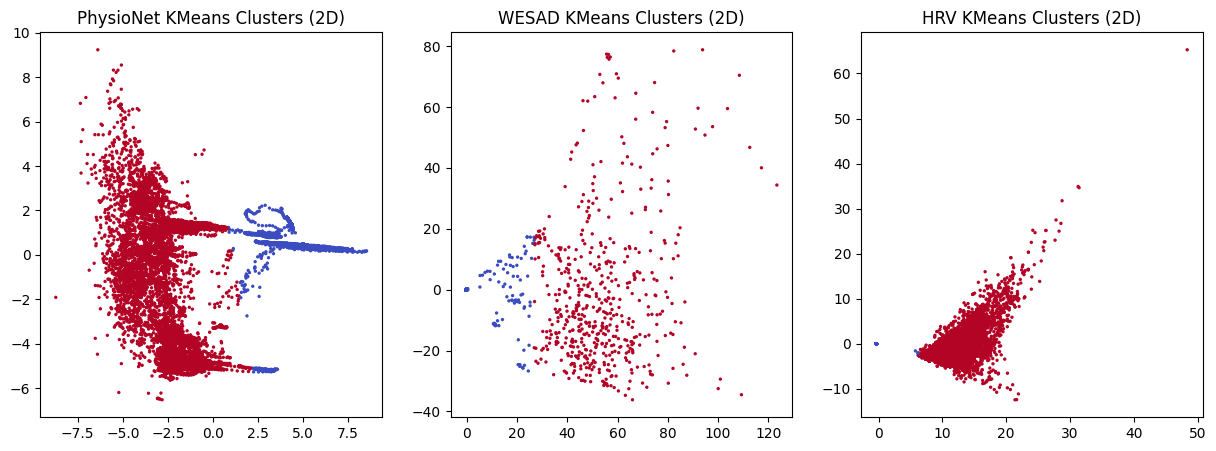

In [39]:
plt.figure(figsize=(15,5))

# PhysioNet
plt.subplot(1,3,1)
plt.scatter(X_physio_pca[:,0], X_physio_pca[:,1], c=physio_clusters, cmap='coolwarm', s=2)
plt.title("PhysioNet KMeans Clusters (2D)")

# WESAD
plt.subplot(1,3,2)
plt.scatter(X_wesad_pca[:,0], X_wesad_pca[:,1], c=wesad_clusters, cmap='coolwarm', s=2)
plt.title("WESAD KMeans Clusters (2D)")

# HRV
plt.subplot(1,3,3)
plt.scatter(X_hrv_pca[:,0], X_hrv_pca[:,1], c=hrv_clusters, cmap='coolwarm', s=2)
plt.title("HRV KMeans Clusters (2D)")

plt.show()


Assign Cluster Labels to Original Features

In [41]:
feature_stats = ['mean', 'std', 'min', 'max', 'slope', 'energy']
cols_physio_full = [f"{ch}_{stat}" for ch in cols_physio for stat in feature_stats]

# Now create DataFrame
physio_df = pd.DataFrame(X_physio_std, columns=cols_physio_full)
physio_df['cluster'] = physio_clusters

print("✅ Cluster labels added to PhysioNet features")
print(physio_df.head())


✅ Cluster labels added to PhysioNet features
   EDA_mean    EDA_std   EDA_min   EDA_max  EDA_slope  EDA_energy   HR_mean  \
0 -6.084266  17.272559 -8.359022  1.741745 -30.384690    5.255872 -0.938405   
1 -6.692040   0.885580 -7.805048 -6.169002   2.787116    5.613103 -0.540058   
2 -6.682425  -0.082161 -6.982023 -6.215348  -0.009097    5.594310 -0.154700   
3 -6.693226   0.382270 -7.237821 -6.076212   0.547643    5.613584  0.065002   
4 -6.474926   1.821285 -7.237821 -5.734496   1.525006    5.247284 -0.239256   

      HR_std    HR_min    HR_max  ...     z_max    z_slope  z_energy  \
0  33.496913 -5.415679 -0.372574  ...  0.993252  10.293181 -1.634480   
1   3.673819 -0.803636 -0.269823  ...  1.120381   9.663179 -0.839401   
2  11.311437 -0.560286  0.372818  ...  1.374639   1.893153  0.133340   
3   6.372621 -0.255009  0.372818  ...  1.394198   3.678159  0.547341   
4   8.445310 -0.583024  0.248988  ...  1.394198  -0.731855  0.640647   

   acc_mag_mean  acc_mag_std  acc_mag_min  acc_

In [42]:
print("Cluster counts for PhysioNet:")
print(physio_df['cluster'].value_counts())


Cluster counts for PhysioNet:
cluster
1    34890
0    18758
Name: count, dtype: int64


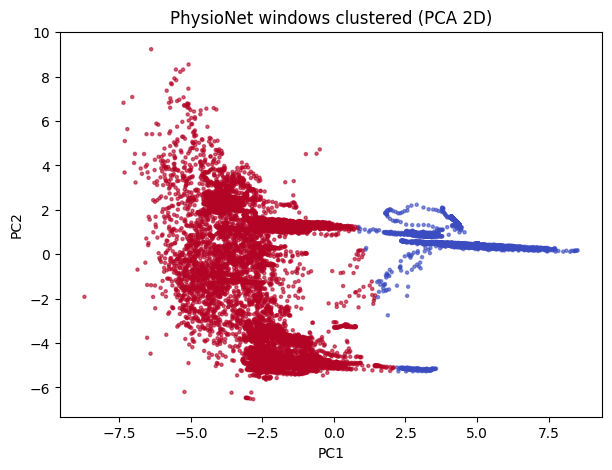

In [43]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_physio_std)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=physio_df['cluster'], cmap='coolwarm', s=5, alpha=0.6)
plt.title("PhysioNet windows clustered (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# -------------------------
# 1️⃣ Datasets dictionary
# -------------------------
datasets = {
    "PhysioNet": {"X": X_physio_train_feats},  # PhysioNet features
    "WESAD": {"X": X_wesad_train_feats},      # WESAD features
    "HRV": {"X": X_hrv_std}                   # HRV standardized features
}



# -------------------------
# 2️⃣ Clustering + Visualization + Silhouette
# -------------------------
for name, data in datasets.items():
    print(f"\n🔹 Processing {name} dataset...")

    X = data["X"]
    print(f"Original shape: {X.shape}")

    # Standardize features
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    print(f"✅ Features standardized. Shape: {X_std.shape}")

    # KMeans clustering
    print(f"Running KMeans for {name} with 2 clusters...")
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_std)
    print(f"✅ KMeans complete. Cluster counts: {np.bincount(clusters)}")

    # Silhouette score
    if len(np.unique(clusters)) > 1:
        sil_score = silhouette_score(X_std, clusters)
        print(f"Silhouette Score: {sil_score:.4f}")
    else:
        sil_score = None
        print("⚠️ Only one cluster present, silhouette score not defined.")

    # Add cluster labels to DataFrame
    df = pd.DataFrame(X_std, columns=[f"feat_{i}" for i in range(X_std.shape[1])])
    df['cluster'] = clusters
    data['df'] = df
    data['clusters'] = clusters
    data['silhouette'] = sil_score

    # PCA 2D visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_std)

    plt.figure(figsize=(7,5))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='coolwarm', s=5, alpha=0.6)
    plt.title(f"{name} windows clustered (PCA 2D)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

    # Cluster distribution summary
    cluster_counts = np.bincount(clusters)
    print(f"Cluster distribution: {dict(enumerate(cluster_counts))}")
    print(f"✅ {name} clustering + visualization complete.")

# -------------------------
# 3️⃣ Comparison Table
# -------------------------
print("\n🔹 Cluster Summary Across Datasets:")
for name, data in datasets.items():
    clusters = data['clusters']
    sil_score = data['silhouette']
    cluster_counts = np.bincount(clusters) if len(clusters) > 0 else []
    print(f"{name}: Silhouette={sil_score}, Counts={dict(enumerate(cluster_counts))}")


NameError: name 'X_physio_train_feats' is not defined